In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv('./data/train_3406.csv')

In [3]:
data_test = pd.read_csv('./data/test_3406.csv')

In [4]:
#技術指標
#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#均價線
def AVL(df):#, tick_N):
    AVL =  pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index, columns = ['AVL'])  
    AVL['AVL'] = np.cumsum(df['DealPrice']*df['DealQty']) / np.cumsum(df['DealQty'])
    AVL['%AVL'] = df['mid1'] / AVL['AVL'] - 1
    return AVL

#布林通道
def BBANDS(df, n, multiple, tick_N):  
    MA = df.rolling(n).mean()
    #%change
    MA_ = MA / MA.shift(tick_N) -1
    MSD = df.rolling(n).std()
    ub1 =  MA + multiple * MSD
    #%change
    ub1_ = ub1 / ub1.shift(tick_N) -1
    uB1 = pd.DataFrame(ub1_, index = df.index, columns = df.columns)  
    lb1 =  MA - multiple * MSD
    #%change
    lb1_ = lb1 / lb1.shift(tick_N) -1
    lB1 = pd.DataFrame(lb1_, index = df.index, columns = df.columns)  
    b2 = (df - MA + multiple * MSD) / (2 * multiple * MSD)  
    B2 = pd.DataFrame(b2, index = df.index, columns = df.columns)  
    BBAND = pd.concat([uB1, lB1, B2], keys = ['UpperBand', 'LowerBand', '%B'], axis = 1)
    BBAND.columns = ['UpperBand', 'LowerBand', '%B']
    return BBAND

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow, C_price_name='mid1'):   
    EMAfast = df[C_price_name].ewm(span = n_fast, min_periods = n_slow - 1).mean() 
    EMAslow = df[C_price_name].ewm(span = n_slow, min_periods = n_slow - 1).mean() 
    #短EMA-長EMA
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(MACD.ewm(span = 9, min_periods = 8).mean(), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    MACD = pd.concat([MACD, MACDsign, MACDdiff], axis = 1)
    return MACD

#generate features
def AlphaGenerate_Tick(original_data,bb=False,avl=False,spread=False,macd=False,mid=False,price_diff=False,
                       price_mean=False,qty_mean=False,acc_diff=False,dt1p=False,dt5p=False,dt10p=False,
                      cross1=False,cross5=False,cross10=False,spread_pq=False,price_diff_pq=False,value=False,
                      spread_pct_pq=False,pq_mean=False,acc_diff_pq=False,dt1_pq=False,dt5_pq=False,dt10_pq=False,
                      ma=False,dt1q=False,dt5q=False,dt10q=False):
    #copy
    data=original_data.copy()
    #mid1
    data['mid1'] = (data['Ask1'] + data['Bid1']) / 2
    #some index's ask1 = 0, we change that mid1 to bid1
    idx = data[data['Ask1'] == 0].index
    for i in idx:
        data['mid1'].iloc[i] = data['Bid1'].iloc[i]
    #ask and askqty <-> bid and bidqty if one side = 0
    data['Ask1'][data['Ask1']==0]=data['Bid1']
    data['Ask2'][data['Ask2']==0]=data['Bid2']
    data['Ask3'][data['Ask3']==0]=data['Bid3']
    data['Ask4'][data['Ask4']==0]=data['Bid4']
    data['Ask5'][data['Ask5']==0]=data['Bid5']
    data['AskQty1'][data['AskQty1']==0]=data['BidQty1']
    data['AskQty2'][data['AskQty2']==0]=data['BidQty2']
    data['AskQty3'][data['AskQty3']==0]=data['BidQty3']
    data['AskQty4'][data['AskQty4']==0]=data['BidQty4']
    data['AskQty5'][data['AskQty5']==0]=data['BidQty5']
    data['Bid1'][data['Bid1']==0]=data['Ask1']
    data['Bid2'][data['Bid2']==0]=data['Ask2']
    data['Bid3'][data['Bid3']==0]=data['Ask3']
    data['Bid4'][data['Bid4']==0]=data['Ask4']
    data['Bid5'][data['Bid5']==0]=data['Ask5']
    data['BidQty1'][data['BidQty1']==0]=data['AskQty1']
    data['BidQty2'][data['BidQty2']==0]=data['AskQty2']
    data['BidQty3'][data['BidQty3']==0]=data['AskQty3']
    data['BidQty4'][data['BidQty4']==0]=data['AskQty4']
    data['BidQty5'][data['BidQty5']==0]=data['AskQty5']
    #df to save
    df_date = pd.DataFrame()
    date_idx = data['Date'].unique()
    #value
    if value == True:
        data['Ask1_value'] = data['Ask1']*data['AskQty1']
        data['Ask2_value'] = data['Ask2']*data['AskQty2']
        data['Ask3_value'] = data['Ask3']*data['AskQty3']
        data['Ask4_value'] = data['Ask4']*data['AskQty4']
        data['Ask5_value'] = data['Ask5']*data['AskQty5']
        data['Bid1_value'] = data['Bid1']*data['BidQty1']
        data['Bid2_value'] = data['Bid2']*data['BidQty2']
        data['Bid3_value'] = data['Bid3']*data['BidQty3']
        data['Bid4_value'] = data['Bid4']*data['BidQty4']
        data['Bid5_value'] = data['Bid5']*data['BidQty5']
    #MA
    if ma == True:
        data['MA50_ask1']=MA(data['Ask1_value'], 50)-data['Ask1_value']
        data['MA50_ask2']=MA(data['Ask2_value'], 50)-data['Ask2_value']
        data['MA50_ask3']=MA(data['Ask3_value'], 50)-data['Ask3_value']
        data['MA50_ask4']=MA(data['Ask4_value'], 50)-data['Ask4_value']
        data['MA50_ask5']=MA(data['Ask5_value'], 50)-data['Ask5_value']
        data['MA50_bid1']=MA(data['Bid1_value'], 50)-data['Bid1_value']
        data['MA50_bid2']=MA(data['Bid2_value'], 50)-data['Bid2_value']
        data['MA50_bid3']=MA(data['Bid3_value'], 50)-data['Bid3_value']
        data['MA50_bid4']=MA(data['Bid4_value'], 50)-data['Bid4_value']
        data['MA50_bid5']=MA(data['Bid5_value'], 50)-data['Bid5_value']
        data['MA100_ask1']=MA(data['Ask1_value'], 100)-data['Ask1_value']
        data['MA100_ask2']=MA(data['Ask2_value'], 100)-data['Ask2_value']
        data['MA100_ask3']=MA(data['Ask3_value'], 100)-data['Ask3_value']
        data['MA100_ask4']=MA(data['Ask4_value'], 100)-data['Ask4_value']
        data['MA100_ask5']=MA(data['Ask5_value'], 100)-data['Ask5_value']
        data['MA100_bid1']=MA(data['Bid1_value'], 100)-data['Bid1_value']
        data['MA100_bid2']=MA(data['Bid2_value'], 100)-data['Bid2_value']
        data['MA100_bid3']=MA(data['Bid3_value'], 100)-data['Bid3_value']
        data['MA100_bid4']=MA(data['Bid4_value'], 100)-data['Bid4_value']
        data['MA100_bid5']=MA(data['Bid5_value'], 100)-data['Bid5_value']
        ##add MA150、200
        #data['MA150_ask1']=MA(data['Ask1_value'], 150)-data['Ask1_value']
        #data['MA150_ask2']=MA(data['Ask2_value'], 150)-data['Ask2_value']
        #data['MA150_ask3']=MA(data['Ask3_value'], 150)-data['Ask3_value']
        #data['MA150_ask4']=MA(data['Ask4_value'], 150)-data['Ask4_value']
        #data['MA150_ask5']=MA(data['Ask5_value'], 150)-data['Ask5_value']
        #data['MA150_bid1']=MA(data['Bid1_value'], 150)-data['Bid1_value']
        #data['MA150_bid2']=MA(data['Bid2_value'], 150)-data['Bid2_value']
        #data['MA150_bid3']=MA(data['Bid3_value'], 150)-data['Bid3_value']
        #data['MA150_bid4']=MA(data['Bid4_value'], 150)-data['Bid4_value']
        #data['MA150_bid5']=MA(data['Bid5_value'], 150)-data['Bid5_value']
        #data['MA200_ask1']=MA(data['Ask1_value'], 200)-data['Ask1_value']
        #data['MA200_ask2']=MA(data['Ask2_value'], 200)-data['Ask2_value']
        #data['MA200_ask3']=MA(data['Ask3_value'], 200)-data['Ask3_value']
        #data['MA200_ask4']=MA(data['Ask4_value'], 200)-data['Ask4_value']
        #data['MA200_ask5']=MA(data['Ask5_value'], 200)-data['Ask5_value']
        #data['MA200_bid1']=MA(data['Bid1_value'], 200)-data['Bid1_value']
        #data['MA200_bid2']=MA(data['Bid2_value'], 200)-data['Bid2_value']
        #data['MA200_bid3']=MA(data['Bid3_value'], 200)-data['Bid3_value']
        #data['MA200_bid4']=MA(data['Bid4_value'], 200)-data['Bid4_value']
        #data['MA200_bid5']=MA(data['Bid5_value'], 200)-data['Bid5_value']
    for k in date_idx:
        #group with date
        df = data[data.Date == k]    
        ##BBAND
        if bb == True:
            df = pd.concat([df, BBANDS(df[['mid1']], 100, 5, 10)], axis = 1)
        ##AVL
        if avl == True:
            df = pd.concat([df, AVL(df)], axis = 1)
        ##MACD
        if macd == True:
            df = pd.concat([df, MACD(df, 12, 26, C_price_name='mid1')], axis = 1)
        
        #other factors
        if spread == True:
            df['spread1'] = df['Ask1'] - df['Bid1']
            df['spread2'] = df['Ask2'] - df['Bid2']
            df['spread3'] = df['Ask3'] - df['Bid3']
            df['spread4'] = df['Ask4'] - df['Bid4']
            df['spread5'] = df['Ask5'] - df['Bid5']
        #spread of price x quantity
        #同時考慮價、量(total value)，比較有意義
        if spread_pct_pq == True:
            df['spread1_pct_pq'] = (df['Ask1_value'] / df['Bid1_value']) -1
            df['spread2_pct_pq'] = (df['Ask2_value'] / df['Bid2_value']) -1
            df['spread3_pct_pq'] = (df['Ask3_value'] / df['Bid3_value']) -1
            df['spread4_pct_pq'] = (df['Ask4_value'] / df['Bid4_value']) -1
            df['spread5_pct_pq'] = (df['Ask5_value'] / df['Bid5_value']) -1
        if spread_pq == True:
            df['spread1_pq'] = df['Ask1_value'] - df['Bid1_value']
            df['spread2_pq'] = df['Ask2_value'] - df['Bid2_value'] 
            df['spread3_pq'] = df['Ask3_value'] - df['Bid3_value'] 
            df['spread4_pq'] = df['Ask4_value'] - df['Bid4_value'] 
            df['spread5_pq'] = df['Ask5_value'] - df['Bid5_value'] 
        if mid == True:
            df['mid2'] = (df['Ask2'] + df['Bid2']) / 2
            df['mid3'] = (df['Ask3'] + df['Bid3']) / 2
            df['mid4'] = (df['Ask4'] + df['Bid4']) / 2
            df['mid5'] = (df['Ask5'] + df['Bid5']) / 2
            df['mid1_std'] = df['mid1'].rolling(50).std()
        if price_diff == True:
            df['a51_diff'] = df['Ask5'] - df['Ask1']
            df['b15_diff'] = df['Bid1'] - df['Bid5']
            df['a21_diff_abs'] = np.abs(df['Ask2'] - df['Ask1'])
            df['a32_diff_abs'] = np.abs(df['Ask3'] - df['Ask2'])
            df['a43_diff_abs'] = np.abs(df['Ask4'] - df['Ask3'])
            df['a54_diff_abs'] = np.abs(df['Ask5'] - df['Ask4'])
            df['b21_diff_abs'] = np.abs(df['Bid2'] - df['Bid1'])
            df['b32_diff_abs'] = np.abs(df['Bid3'] - df['Bid2'])
            df['b43_diff_abs'] = np.abs(df['Bid4'] - df['Bid3'])
            df['b54_diff_abs'] = np.abs(df['Bid5'] - df['Bid4'])
        #price diff of price*quantity
        #改掉abs()
        if price_diff_pq == True:
            df['a51_diff_pq'] = df['Ask5_value'] - df['Ask1_value']
            df['b15_diff_pq'] = df['Bid1_value'] - df['Bid5_value']
            df['a21_diff_pq'] = df['Ask2_value'] - df['Ask1_value']
            df['a32_diff_pq'] = df['Ask3_value'] - df['Ask2_value']
            df['a43_diff_pq'] = df['Ask4_value'] - df['Ask3_value']
            df['a54_diff_pq'] = df['Ask5_value'] - df['Ask4_value']
            df['b21_diff_pq'] = df['Bid2_value'] - df['Bid1_value']
            df['b32_diff_pq'] = df['Bid3_value'] - df['Bid2_value']
            df['b43_diff_pq'] = df['Bid4_value'] - df['Bid3_value']
            df['b54_diff_pq'] = df['Bid5_value'] - df['Bid4_value']
        if price_mean == True:
            df['a_mean'] = (df['Ask1'] +df['Ask2'] +df['Ask3'] +df['Ask4'] +df['Ask5']) / 5
            df['b_mean'] = (df['Bid1'] +df['Bid2'] +df['Bid3'] +df['Bid4'] +df['Bid5']) / 5
        if qty_mean == True:
            df['aq_mean'] = (df['AskQty1'] +df['AskQty2'] +df['AskQty3'] +df['AskQty4'] +df['AskQty5']) / 5
            df['bq_mean'] = (df['BidQty1'] +df['BidQty2'] +df['BidQty3'] +df['BidQty4'] +df['BidQty5']) / 5
        if pq_mean == True:
            df['a_pq_mean'] = (df['Ask1_value']+df['Ask2_value']+df['Ask3_value']+df['Ask4_value']+df['Ask5_value'])/5
            df['b_pq_mean'] = (df['Bid1_value']+df['Bid2_value']+df['Bid3_value']+df['Bid4_value']+df['Bid5_value'])/5
        if acc_diff == True:
            df['p_acc_diff'] = (df['Ask1'] - df['Bid1']) +(df['Ask2'] - df['Bid2']) + (df['Ask3'] - df['Bid3']) + (df['Ask4'] - df['Bid4']) + (df['Ask5'] - df['Bid5'])
            df['q_acc_diff'] = (df['AskQty1'] - df['BidQty1']) +(df['AskQty2'] - df['BidQty2']) + (df['AskQty3'] - df['BidQty3']) + (df['AskQty4'] - df['BidQty4']) + (df['AskQty5'] - df['BidQty5'])
        if acc_diff_pq == True:
            df['p_acc_diff_pq'] = (df['Ask1_value'] - df['Bid1_value']) +(df['Ask2_value'] - df['Bid2_value']) + (df['Ask3_value'] - df['Bid3_value']) + (df['Ask4_value'] - df['Bid4_value']) + (df['Ask5_value'] - df['Bid5_value'])
        if dt1p == True:
            #1 tick
            df['da1_dt_1'] = df['Ask1']-df['Ask1'].shift(1)
            df['da2_dt_1'] = df['Ask2']-df['Ask2'].shift(1)
            df['da3_dt_1'] = df['Ask3']-df['Ask3'].shift(1)
            df['da4_dt_1'] = df['Ask4']-df['Ask4'].shift(1)
            df['da5_dt_1'] = df['Ask5']-df['Ask5'].shift(1)
            df['db1_dt_1'] = df['Bid1']-df['Bid1'].shift(1)
            df['db2_dt_1'] = df['Bid2']-df['Bid2'].shift(1)
            df['db3_dt_1'] = df['Bid3']-df['Bid3'].shift(1)
            df['db4_dt_1'] = df['Bid4']-df['Bid4'].shift(1)
            df['db5_dt_1'] = df['Bid5']-df['Bid5'].shift(1)
            #fillna to 0
            df[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']] = df[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']].fillna(value = 0)
        
        if dt1_pq == True:
            #1 tick
            df['da1_dt_1_pq'] = df['Ask1_value']-df['Ask1_value'].shift(1)
            df['da2_dt_1_pq'] = df['Ask2_value']-df['Ask2_value'].shift(1)
            df['da3_dt_1_pq'] = df['Ask3_value']-df['Ask3_value'].shift(1)
            df['da4_dt_1_pq'] = df['Ask4_value']-df['Ask4_value'].shift(1)
            df['da5_dt_1_pq'] = df['Ask5_value']-df['Ask5_value'].shift(1)
            df['db1_dt_1_pq'] = df['Bid1_value']-df['Bid1_value'].shift(1)
            df['db2_dt_1_pq'] = df['Bid2_value']-df['Bid2_value'].shift(1)
            df['db3_dt_1_pq'] = df['Bid3_value']-df['Bid3_value'].shift(1)
            df['db4_dt_1_pq'] = df['Bid4_value']-df['Bid4_value'].shift(1)
            df['db5_dt_1_pq'] = df['Bid5_value']-df['Bid5_value'].shift(1)
        if dt5p == True:
            #5 ticks
            df['da1_dt_5'] = df['Ask1']-df['Ask1'].shift(5)
            df['da2_dt_5'] = df['Ask2']-df['Ask2'].shift(5)
            df['da3_dt_5'] = df['Ask3']-df['Ask3'].shift(5)
            df['da4_dt_5'] = df['Ask4']-df['Ask4'].shift(5)
            df['da5_dt_5'] = df['Ask5']-df['Ask5'].shift(5)
            df['db1_dt_5'] = df['Bid1']-df['Bid1'].shift(5)
            df['db2_dt_5'] = df['Bid2']-df['Bid2'].shift(5)
            df['db3_dt_5'] = df['Bid3']-df['Bid3'].shift(5)
            df['db4_dt_5'] = df['Bid4']-df['Bid4'].shift(5)
            df['db5_dt_5'] = df['Bid5']-df['Bid5'].shift(5)
            #fill na to 0
            df[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']] = df[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']].fillna(value = 0)
        if dt5_pq == True:
            #1 tick
            df['da1_dt_5_pq'] = df['Ask1_value']-df['Ask1_value'].shift(5)
            df['da2_dt_5_pq'] = df['Ask2_value']-df['Ask2_value'].shift(5)
            df['da3_dt_5_pq'] = df['Ask3_value']-df['Ask3_value'].shift(5)
            df['da4_dt_5_pq'] = df['Ask4_value']-df['Ask4_value'].shift(5)
            df['da5_dt_5_pq'] = df['Ask5_value']-df['Ask5_value'].shift(5)
            df['db1_dt_5_pq'] = df['Bid1_value']-df['Bid1_value'].shift(5)
            df['db2_dt_5_pq'] = df['Bid2_value']-df['Bid2_value'].shift(5)
            df['db3_dt_5_pq'] = df['Bid3_value']-df['Bid3_value'].shift(5)
            df['db4_dt_5_pq'] = df['Bid4_value']-df['Bid4_value'].shift(5)
            df['db5_dt_5_pq'] = df['Bid5_value']-df['Bid5_value'].shift(5)                                              
        if dt10p == True:
            ##10 ticks
            df['da1_dt_10'] = df['Ask1']-df['Ask1'].shift(10)
            df['da2_dt_10'] = df['Ask2']-df['Ask2'].shift(10)
            df['da3_dt_10'] = df['Ask3']-df['Ask3'].shift(10)
            df['da4_dt_10'] = df['Ask4']-df['Ask4'].shift(10)
            df['da5_dt_10'] = df['Ask5']-df['Ask5'].shift(10)
            df['db1_dt_10'] = df['Bid1']-df['Bid1'].shift(10)
            df['db2_dt_10'] = df['Bid2']-df['Bid2'].shift(10)
            df['db3_dt_10'] = df['Bid3']-df['Bid3'].shift(10)
            df['db4_dt_10'] = df['Bid4']-df['Bid4'].shift(10)
            df['db5_dt_10'] = df['Bid5']-df['Bid5'].shift(10)
            #fill na to 0
            df[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']] = df[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']].fillna(value = 0)
        if dt10_pq == True:
            #1 tick
            df['da1_dt_10_pq'] = df['Ask1_value']-df['Ask1_value'].shift(10)
            df['da2_dt_10_pq'] = df['Ask2_value']-df['Ask2_value'].shift(10)
            df['da3_dt_10_pq'] = df['Ask3_value']-df['Ask3_value'].shift(10)
            df['da4_dt_10_pq'] = df['Ask4_value']-df['Ask4_value'].shift(10)
            df['da5_dt_10_pq'] = df['Ask5_value']-df['Ask5_value'].shift(10)
            df['db1_dt_10_pq'] = df['Bid1_value']-df['Bid1_value'].shift(10)
            df['db2_dt_10_pq'] = df['Bid2_value']-df['Bid2_value'].shift(10)
            df['db3_dt_10_pq'] = df['Bid3_value']-df['Bid3_value'].shift(10)
            df['db4_dt_10_pq'] = df['Bid4_value']-df['Bid4_value'].shift(10)
            df['db5_dt_10_pq'] = df['Bid5_value']-df['Bid5_value'].shift(10)                                              
        if dt1q == True:
            #1 tick
            df['daq1_dt_1'] = df['AskQty1'] - df['AskQty1'].shift(1)
            #單個變化量與平均變化量的差
            #df['daq1_dt_1'] = (df['daq1_dt_1'] / df['daq1_dt_1'].expanding().mean()) - 1
            df['daq2_dt_1'] = df['AskQty2'] - df['AskQty2'].shift(1)
            df['daq3_dt_1'] = df['AskQty3'] - df['AskQty3'].shift(1)
            df['daq4_dt_1'] = df['AskQty4'] - df['AskQty4'].shift(1)
            df['daq5_dt_1'] = df['AskQty5'] - df['AskQty5'].shift(1)
            df['dbq1_dt_1'] = df['BidQty1'] - df['BidQty1'].shift(1)
            df['dbq2_dt_1'] = df['BidQty2'] - df['BidQty2'].shift(1)
            df['dbq3_dt_1'] = df['BidQty3'] - df['BidQty3'].shift(1)
            df['dbq4_dt_1'] = df['BidQty4'] - df['BidQty4'].shift(1)
            df['dbq5_dt_1'] = df['BidQty5'] - df['BidQty5'].shift(1)
            #fill na to 0
            df[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']] = df[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']].fillna(value = 0)
        if dt5q == True:
            #5 ticks
            df['daq1_dt_5'] = df['AskQty1'] - df['AskQty1'].shift(5)
            df['daq2_dt_5'] = df['AskQty2'] - df['AskQty2'].shift(5)
            df['daq3_dt_5'] = df['AskQty3'] - df['AskQty3'].shift(5)
            df['daq4_dt_5'] = df['AskQty4'] - df['AskQty4'].shift(5)
            df['daq5_dt_5'] = df['AskQty5'] - df['AskQty5'].shift(5)
            df['dbq1_dt_5'] = df['BidQty1'] - df['BidQty1'].shift(5)
            df['dbq2_dt_5'] = df['BidQty2'] - df['BidQty2'].shift(5)
            df['dbq3_dt_5'] = df['BidQty3'] - df['BidQty3'].shift(5)
            df['dbq4_dt_5'] = df['BidQty4'] - df['BidQty4'].shift(5)
            df['dbq5_dt_5'] = df['BidQty5'] - df['BidQty5'].shift(5)
            #fill na to 0
            df[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']] = df[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']].fillna(value = 0)
        if dt10q == True:
            #10 ticks
            df['daq1_dt_10'] = df['AskQty1'] - df['AskQty1'].shift(10)
            df['daq2_dt_10'] = df['AskQty2'] - df['AskQty2'].shift(10)
            df['daq3_dt_10'] = df['AskQty3'] - df['AskQty3'].shift(10)
            df['daq4_dt_10'] = df['AskQty4'] - df['AskQty4'].shift(10)
            df['daq5_dt_10'] = df['AskQty5'] - df['AskQty5'].shift(10)
            df['dbq1_dt_10'] = df['BidQty1'] - df['BidQty1'].shift(10)
            df['dbq2_dt_10'] = df['BidQty2'] - df['BidQty2'].shift(10)
            df['dbq3_dt_10'] = df['BidQty3'] - df['BidQty3'].shift(10)
            df['dbq4_dt_10'] = df['BidQty4'] - df['BidQty4'].shift(10)
            df['dbq5_dt_10'] = df['BidQty5'] - df['BidQty5'].shift(10)
            #fill na to 0
            df[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']] = df[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']].fillna(value = 0)
        #features crosses
        #dt1
        if (cross1 == True) and (dt1 == True):
            #ask
            df['aq1dt1_cross'] = df['da1_dt_1'] * df['daq1_dt_1']
            df['aq2dt1_cross'] = df['da2_dt_1'] * df['daq2_dt_1']
            df['aq3dt1_cross'] = df['da3_dt_1'] * df['daq3_dt_1']
            df['aq4dt1_cross'] = df['da4_dt_1'] * df['daq4_dt_1']
            df['aq5dt1_cross'] = df['da5_dt_1'] * df['daq5_dt_1']
            #bid
            df['bq1dt1_cross'] = df['db1_dt_1'] * df['dbq1_dt_1']
            df['bq2dt1_cross'] = df['db2_dt_1'] * df['dbq2_dt_1']
            df['bq3dt1_cross'] = df['db3_dt_1'] * df['dbq3_dt_1']
            df['bq4dt1_cross'] = df['db4_dt_1'] * df['dbq4_dt_1']
            df['bq5dt1_cross'] = df['db5_dt_1'] * df['dbq5_dt_1']
        #dt5
        if (cross5 == True) and (dt5 == True):
            #ask
            df['aq1dt5_cross'] = df['da1_dt_5'] * df['daq1_dt_5']
            df['aq2dt5_cross'] = df['da2_dt_5'] * df['daq2_dt_5']
            df['aq3dt5_cross'] = df['da3_dt_5'] * df['daq3_dt_5']
            df['aq4dt5_cross'] = df['da4_dt_5'] * df['daq4_dt_5']
            df['aq5dt5_cross'] = df['da5_dt_5'] * df['daq5_dt_5']
            #bid
            df['bq1dt5_cross'] = df['db1_dt_5'] * df['dbq1_dt_5']
            df['bq2dt5_cross'] = df['db2_dt_5'] * df['dbq2_dt_5']
            df['bq3dt5_cross'] = df['db3_dt_5'] * df['dbq3_dt_5']
            df['bq4dt5_cross'] = df['db4_dt_5'] * df['dbq4_dt_5']
            df['bq5dt5_cross'] = df['db5_dt_5'] * df['dbq5_dt_5']
        #dt10
        if (cross10 == True) and (dt10 == True):
            #ask
            df['aq1dt10_cross'] = df['da1_dt_10'] * df['daq1_dt_10']
            df['aq2dt10_cross'] = df['da2_dt_10'] * df['daq2_dt_10']
            df['aq3dt10_cross'] = df['da3_dt_10'] * df['daq3_dt_10']
            df['aq4dt10_cross'] = df['da4_dt_10'] * df['daq4_dt_10']
            df['aq5dt10_cross'] = df['da5_dt_10'] * df['daq5_dt_10']
            #bid
            df['bq1dt10_cross'] = df['db1_dt_10'] * df['dbq1_dt_10']
            df['bq2dt10_cross'] = df['db2_dt_10'] * df['dbq2_dt_10']
            df['bq3dt10_cross'] = df['db3_dt_10'] * df['dbq3_dt_10']
            df['bq4dt10_cross'] = df['db4_dt_10'] * df['dbq4_dt_10']
            df['bq5dt10_cross'] = df['db5_dt_10'] * df['dbq5_dt_10']
        #concat each date
        df_date = pd.concat([df_date, df])
    #drop nan
    df = df_date.dropna()
    df = df.reset_index(drop = True)
    X = df
    X = X.drop(['Unnamed: 0', 'SeqNumber', 'TimeStamp', 'Pid', 'TxTime', 'SourceType'], axis = 1)
    return X, df

#normalize
def normalize(df):
    norm = df.apply(lambda x: x / (np.std(x)))
    return norm

#scale back to the true range
def true_range(df, x, response):
    X = x * np.std(df[response])
    return X

#rolling windows
def train_windows(df, response, ref_day=10, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day+1):
        #扣掉response
        #記得最後一行要放response
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day-1:i+ref_day][response]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    #first layer
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    #first drop out layer(drop 50% of the previous one to avoid over-fitting)
    model.add(Dropout(0.5))
    #second layer
    model.add(LSTM(256, return_sequences=True))
    #second drop out layer
    model.add(Dropout(0.5))
    #add dense in every time step, dimension -> 1
    model.add(TimeDistributed(Dense(1)))
    #third drop out layer
    model.add(Dropout(0.5))
    #flatten: 多維 -> 一維
    model.add(Flatten())
    #forth drop out layer
    model.add(Dropout(0.5))
    #dense layer
    model.add(Dense(10,activation='linear'))
    #1 -> output dimension
    model.add(Dense(1,activation='linear'))
    #change learning rate 0.001 -> 0.0005
    adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss="mean_squared_error", optimizer=adam,metrics=['mean_squared_error'])
    #using MSE
    #model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

In [5]:
data_train['Date'] = pd.to_datetime(data_train['TxTime'])
data_train['Date'] = [str(x)[0:10] for x in data_train['Date']]
data_test['Date'] = pd.to_datetime(data_test['TxTime'])
data_test['Date'] = [str(x)[0:10] for x in data_test['Date']]

In [6]:
#drop 3/23 3/24, 資料有缺值 9:22 -> 9:41
data_train = data_train[data_train.Date != '2020-03-23']
data_train = data_train[data_train.Date != '2020-03-24']
data_train = data_train.reset_index(drop = True)

In [7]:
X_in, data_train1 = AlphaGenerate_Tick(data_train,value=True,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)
X_in.iloc[:,34:]

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,daq1_dt_10,daq2_dt_10,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10
0,29218.77,-29412.64,15014.88,-12735.12,2499.20,2846.61,4551.72,-8129.72,803.09,1703.76,...,-128.0,119.0,-48.0,50.0,-4.0,0.0,-2.0,2.0,0.0,0.0
1,28515.43,-28463.08,14606.82,-12335.16,2467.08,2798.75,4567.52,-7805.86,858.15,1640.35,...,-125.0,119.0,-48.0,50.0,-4.0,0.0,-2.0,2.0,0.0,0.0
2,27812.11,-27513.52,14198.76,-11935.20,2434.96,2750.89,4583.32,-7482.00,913.21,1576.94,...,-5.0,-5.0,0.0,0.0,0.0,-4.0,-37.0,33.0,8.0,-5.0
3,27881.89,20753.38,-32713.74,7283.70,-17195.20,2726.94,4599.12,-7158.14,968.27,1513.53,...,-8.0,-121.0,119.0,-48.0,50.0,-4.0,-37.0,33.0,8.0,-5.0
4,25585.57,-26580.06,14380.20,-11519.34,2770.68,2726.91,4614.94,-6842.20,967.91,1205.40,...,-4.0,0.0,0.0,0.0,0.0,-4.0,-37.0,33.0,8.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385877,-2557.66,-4052.13,-2466.21,1903.25,1381.49,1583.13,-2066.18,1474.48,-1795.73,1338.74,...,7.0,22.0,8.0,-13.0,-4.0,-17.0,14.0,-9.0,10.0,-11.0
385878,-2530.97,-3856.54,-2208.09,1796.63,1319.26,1849.50,-1942.04,1386.18,-1680.75,1241.80,...,7.0,22.0,8.0,-13.0,-4.0,-18.0,14.0,-9.0,11.0,-11.0
385879,-2504.28,-3660.95,-2386.07,1681.11,1257.03,1672.37,-1817.90,1297.88,-1565.77,1144.86,...,7.0,0.0,1.0,0.0,0.0,6.0,-1.0,0.0,0.0,0.0
385880,-2477.59,-3465.36,-2119.05,1565.59,1194.80,2807.99,-1693.76,1209.58,-1450.79,1047.92,...,7.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0


In [8]:
#X_in_normal = normalize(X_in.iloc[:,34:])
#Y
tick_N = 10
y=(data_train1['Ask1']+data_train1['Bid1'])/2
y[data_train1['Bid1']==0]=data_train1['Ask1']
y[data_train1['Ask1']==0]=data_train1['Bid1']
y=y.shift(-tick_N)/y-1
y[data_train1['Date']!=data_train1['Date'].shift(-tick_N)]=0.
y.fillna(0,inplace=True)
y.replace([np.inf, -np.inf], 0,inplace=True)
#X_in_normal['return_10t'] = y
X_in['return_10t'] = y
X_in_normal = normalize(X_in.iloc[:,34:])

In [9]:
#test set
X_out, data_test1 = AlphaGenerate_Tick(data_test,value=True,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)
#X_out_normal = normalize(X_out.iloc[:,34:])
#Y
y=(data_test1['Ask1']+data_test1['Bid1'])/2
y[data_test1['Bid1']==0]=data_test1['Ask1']
y[data_test1['Ask1']==0]=data_test1['Bid1']
y=y.shift(-tick_N)/y-1
y[data_test1['Date']!=data_test1['Date'].shift(-tick_N)]=0.
y.fillna(0,inplace=True)
y.replace([np.inf, -np.inf], 0,inplace=True)
#X_out_normal['return_10t'] = y
X_out['return_10t'] = y
X_out_normal = normalize(X_out.iloc[:,34:])

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [10]:
train_pred_return = pd.read_csv('./data/train_return_mix1.csv')
test_pred_return  = pd.read_csv('./data/test_return_mix1.csv')

In [11]:
train_pred_return = train_pred_return.drop(['Unnamed: 0'], axis = 1)
train_pred_return.columns = ['pred_return']
train_pred_return

,pred_return
0,0.000055
1,0.000036
2,-0.000145
3,-0.000324
4,-0.000411
...,...
385867,-0.000126
385868,-0.000116
385869,-0.000161
385870,-0.000069


In [12]:
test_pred_return = test_pred_return.drop(['Unnamed: 0'], axis = 1)
test_pred_return.columns = ['pred_return']
test_pred_return

,pred_return
0,-0.000252
1,-0.000215
2,-0.000202
3,-0.000211
4,-0.000218
...,...
106350,0.000015
106351,-0.000028
106352,0.000038
106353,0.000044


In [13]:
df_train = X_in.iloc[10:]
df_train = df_train.reset_index(drop = True)
df_train = pd.concat([df_train, train_pred_return], axis = 1)
df_train

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,return_10t,pred_return
0,398.0,1.0,2.0,397.0,398.0,2.0,2,396.5,399.0,125,...,0.0,0.0,0.0,1.0,-1.0,-39.0,33.0,8.0,0.003145,0.000055
1,399.0,1.0,2.0,397.0,399.0,124.0,2,396.5,399.5,6,...,48.0,-50.0,4.0,1.0,-1.0,-39.0,33.0,8.0,0.001884,0.000036
2,0.0,0.0,1.0,398.5,399.0,124.0,2,397.0,399.5,6,...,48.0,-50.0,4.0,0.0,-1.0,-40.0,-6.0,41.0,0.000000,-0.000145
3,399.0,1.0,1.0,398.5,399.0,123.0,2,397.0,399.5,6,...,-71.0,-2.0,-46.0,0.0,-1.0,-40.0,-6.0,41.0,0.000000,-0.000324
4,399.0,22.0,1.0,398.5,399.0,101.0,2,397.0,399.5,6,...,48.0,-50.0,4.0,0.0,-1.0,-40.0,-6.0,41.0,0.000000,-0.000411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385867,443.5,2.0,8.0,443.5,444.0,8.0,24,443.0,444.5,23,...,8.0,-13.0,-4.0,-17.0,14.0,-9.0,10.0,-11.0,0.000000,-0.000126
385868,443.5,1.0,7.0,443.5,444.0,8.0,24,443.0,444.5,23,...,8.0,-13.0,-4.0,-18.0,14.0,-9.0,11.0,-11.0,0.000000,-0.000116
385869,0.0,0.0,7.0,443.5,444.0,8.0,24,443.0,444.5,23,...,1.0,0.0,0.0,6.0,-1.0,0.0,0.0,0.0,0.000000,-0.000161
385870,443.5,3.0,4.0,443.5,444.0,8.0,24,443.0,444.5,23,...,1.0,0.0,0.0,-2.0,-1.0,0.0,0.0,0.0,0.000000,-0.000069


In [14]:
df_test = X_out.iloc[10:]
df_test = df_test.reset_index(drop = True)
df_test = pd.concat([df_test, test_pred_return], axis = 1)
df_test

,DealPrice,DealQty,BidQty1,Bid1,Ask1,AskQty1,BidQty2,Bid2,Ask2,AskQty2,...,daq3_dt_10,daq4_dt_10,daq5_dt_10,dbq1_dt_10,dbq2_dt_10,dbq3_dt_10,dbq4_dt_10,dbq5_dt_10,return_10t,pred_return
0,0.0,0.0,1.0,437.0,437.5,5.0,3,436.5,438.0,15,...,0.0,1.0,0.0,-1.0,-8.0,-2.0,-26.0,39.0,-0.000572,-0.000252
1,0.0,0.0,2.0,437.0,437.5,5.0,3,436.5,438.0,15,...,0.0,1.0,0.0,0.0,-8.0,-2.0,-27.0,39.0,-0.000572,-0.000215
2,0.0,0.0,3.0,437.0,437.5,5.0,3,436.5,438.0,15,...,0.0,1.0,0.0,1.0,-8.0,-2.0,-27.0,39.0,-0.000572,-0.000202
3,0.0,0.0,3.0,437.0,437.5,6.0,3,436.5,438.0,15,...,0.0,1.0,0.0,1.0,-8.0,-2.0,-27.0,39.0,0.000000,-0.000211
4,0.0,0.0,3.0,437.0,437.5,6.0,4,436.5,438.0,15,...,0.0,1.0,0.0,1.0,-7.0,-2.0,-27.0,39.0,0.000000,-0.000218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106350,0.0,0.0,11.0,465.5,466.0,1.0,40,465.0,466.5,9,...,0.0,1.0,0.0,-28.0,-9.0,-1.0,27.0,-65.0,0.000000,0.000015
106351,465.5,1.0,10.0,465.5,466.0,1.0,40,465.0,466.5,9,...,-17.0,27.0,6.0,-29.0,-9.0,-1.0,27.0,-65.0,0.000000,-0.000028
106352,0.0,0.0,10.0,465.5,466.0,1.0,41,465.0,466.5,9,...,-17.0,27.0,6.0,-30.0,-8.0,-1.0,27.0,-65.0,0.000000,0.000038
106353,0.0,0.0,10.0,465.5,466.0,1.0,42,465.0,466.5,9,...,-17.0,27.0,6.0,0.0,2.0,-4.0,0.0,0.0,0.000000,0.000044


In [15]:
np.sum(df_train['pred_return'] > 0.001)

301

In [16]:
np.sum(df_train['pred_return'] < -0.001)

69

(-0.01, 0.01)

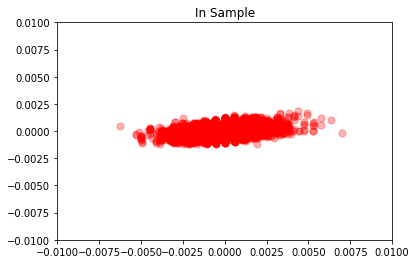

In [17]:
plt.scatter(df_train['return_10t'], df_train['pred_return'], s=50, c='red', alpha=.3)
plt.title('In Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)

Text(0.5, 1.0, 'Predicted Return (train)')

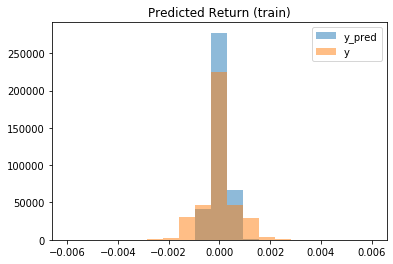

In [18]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_train['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_train['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (train)')

In [19]:
np.sum(df_test['pred_return'] > 0.001)

4

In [20]:
np.sum(df_test['pred_return'] < -0.001)

2

(-0.01, 0.01)

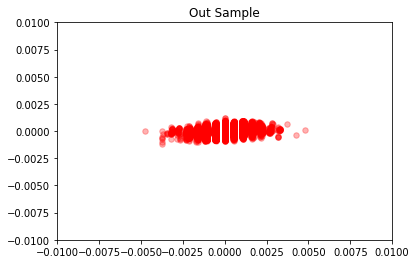

In [21]:
plt.scatter(df_test['return_10t'], df_test['pred_return'], s=30, c='red', alpha=.3)
plt.title('Out Sample')
plt.ylim(-0.01, 0.01)
plt.xlim(-0.01, 0.01)

Text(0.5, 1.0, 'Predicted Return (test)')

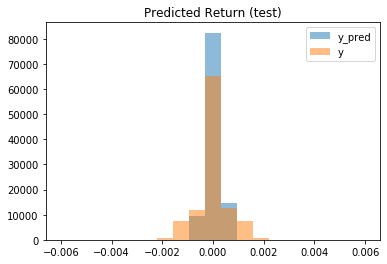

In [22]:
bins = np.linspace(-0.006, 0.006, 20)
plt.hist(df_test['pred_return'], bins, alpha=0.5, label='y_pred')
plt.hist(df_test['return_10t'], bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title('Predicted Return (test)')